# Police Crash Narrative Classification
## Using DistilBERT for E-scooter, E-bike, and Other Classification

This notebook classifies crash narratives into three categories:
- **Other (Non-motorists or Cyclists)**: 45.17%
- **E-scooter**: 34.82%
- **E-bike**: 19.71%

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Install Required Libraries

In [ ]:
!pip install transformers datasets pandas openpyxl scikit-learn torch accelerate matplotlib seaborn --quiet

## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 3. Load and Explore Data

In [3]:
# Load the Excel file
df = pd.read_excel('NEW.xlsx')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (2694, 8)

Columns: ['HSMV_Report_Number', 'Bike Type', 'Narrative', 'Match', 'ZIP_Folder_Location', 'Bike Type Group', 'Final Bike Type', 'FINAL']

First few rows:


,HSMV_Report_Number,Bike Type,Narrative,Match,ZIP_Folder_Location,Bike Type Group,Final Bike Type,FINAL
0,85203537,Pedicab,ID Number Rank Name Troop / Post Officer Agenc...,Yes,S4_Extract_xiangyan_145031_20250507_221605,Other (Non-motorists or Cyclists),Other (Non-motorists or Cyclists),Other (Non-motorists or Cyclists)
1,87436908,Pedicab,Vehicle 1 was stopped in traffic on Universal ...,Yes,S4_Extract_xiangyan_145034_20250507_222144,Other (Non-motorists or Cyclists),Other (Non-motorists or Cyclists),Other (Non-motorists or Cyclists)
2,87441667,Motorized bicycle,Vehicle 1 was traveling East on E. Colonial Dr...,Yes,S4_Extract_xiangyan_145034_20250507_222144,Other (Non-motorists or Cyclists),Other (Non-motorists or Cyclists),Other (Non-motorists or Cyclists)
3,87443630,Motorized bicycle,First Harmful Event Type First Harmful Event 1...,Yes,S4_Extract_xiangyan_145034_20250507_222144,Other (Non-motorists or Cyclists),E-bike,Other (Non-motorists or Cyclists)
4,87469273,E-trike,Drivers Actions at Time of Crash (third) Drive...,Yes,S4_Extract_xiangyan_145035_20250507_222250,E-bike,E-bike,E-bike


In [4]:
# Check class distribution
print("Class Distribution:")
print(df['FINAL'].value_counts())
print("\nPercentages:")
print(df['FINAL'].value_counts(normalize=True) * 100)

Class Distribution:
FINAL
Other (Non-motorists or Cyclists)    1222
E-scooter                             940
E-bike                                532
Name: count, dtype: int64

Percentages:
FINAL
Other (Non-motorists or Cyclists)    45.360059
E-scooter                            34.892353
E-bike                               19.747587
Name: proportion, dtype: float64


In [5]:
# Check for missing values
print("Missing values in Narrative:", df['Narrative'].isna().sum())
print("Missing values in FINAL:", df['FINAL'].isna().sum())

# Sample narratives
print("\nSample narratives:")
for idx, row in df.sample(3).iterrows():
    print(f"\nClass: {row['FINAL']}")
    print(f"Narrative: {row['Narrative'][:200]}...")

Missing values in Narrative: 0
Missing values in FINAL: 0

Sample narratives:

Class: Other (Non-motorists or Cyclists)
Narrative: V1 TRAVELING WESTBOUND ON NW 42ND ST APPROACHING THE INTERSECTION AT NW 12TH PL. NON MOTORIST 1 AND 2, WHO WERE NOT WEARING PROTECTIVE
GEAR, WAS CROSSING NW 12TH PLACE HEADING SOUTHBOUND WHEN V1 AND T...

Class: Other (Non-motorists or Cyclists)
Narrative: On February 2nd, 2018 I Ofc. E. Gould #386 responded to the area of 1115 Palm Bay Rd. "BJ's" in reference to an alleged hit and run. Upon my arrival I made contact with
the cyclist identified to me as...

Class: Other (Non-motorists or Cyclists)
Narrative: E. KJEKSTAD
C
352-251-4020
V01 was traveling westward in the Homosassa River RV Resort, located at 10200 West Fishbowl Drive, approaching lot E-14. NM01, a juvenile, was riding a human
propelled scoot...


## 4. Prepare Data for Training

In [6]:
# Clean data - remove rows with missing values
df_clean = df[['Narrative', 'FINAL']].dropna()

# Create label mapping
label_mapping = {
    'Other (Non-motorists or Cyclists)': 0,
    'E-scooter': 1,
    'E-bike': 2
}

# Reverse mapping for predictions
id2label = {v: k for k, v in label_mapping.items()}
label2id = label_mapping

# Map labels to integers
df_clean['label'] = df_clean['FINAL'].map(label_mapping)

# Rename columns for Hugging Face
df_clean = df_clean.rename(columns={'Narrative': 'text'})

print(f"Clean dataset size: {len(df_clean)}")
print(f"\nLabel distribution:")
print(df_clean['label'].value_counts())

Clean dataset size: 2694

Label distribution:
label
0    1222
1     940
2     532
Name: count, dtype: int64


In [7]:
# Split data into train, validation, and test sets (70-15-15)
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.3,
    random_state=42,
    stratify=df_clean['label']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Train set: 1885 samples
Validation set: 404 samples
Test set: 405 samples


In [8]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 1885
    })
    validation: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 404
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 405
    })
})


## 5. Load Tokenizer and Model

In [9]:
# Using DistilBERT - lightweight and efficient for text classification
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {model.num_parameters():,}")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded: distilbert-base-uncased
Number of parameters: 66,955,779


## 6. Tokenize Data

In [10]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=512  # Max length for narratives
    )

# Tokenize all datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("Tokenization complete!")

Map:   0%|          | 0/1885 [00:00<?, ? examples/s]

Map:   0%|          | 0/404 [00:00<?, ? examples/s]

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

Tokenization complete!


## 7. Handle Class Imbalance

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights to handle imbalance
# Your distribution: Other (45%), E-scooter (35%), E-bike (20%)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights to handle imbalance:")
for label_id, weight in class_weights_dict.items():
    print(f"  {id2label[label_id]}: {weight:.3f}")

# Convert to tensor for the model
class_weights_tensor = torch.tensor(list(class_weights_dict.values()), dtype=torch.float)

Class weights to handle imbalance:
  Other (Non-motorists or Cyclists): 0.735
  E-scooter: 0.955
  E-bike: 1.689


## 8. Define Training Arguments with Early Stopping

In [12]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./crash_classifier_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Increased - early stopping will handle it
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Using F1 for imbalanced classes
    greater_is_better=True,
    push_to_hub=False,
    logging_steps=10,
    warmup_steps=100,
    seed=42,
    save_total_limit=2,  # Only keep 2 best checkpoints
)

# Early stopping: stop if no improvement for 3 epochs
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)

print("Training configuration:")
print(f"  Max epochs: {training_args.num_train_epochs}")
print(f"  Early stopping patience: 3 epochs")
print(f"  Metric for best model: F1 score (better for imbalanced data)")

Training configuration:
  Max epochs: 10
  Early stopping patience: 3 epochs
  Metric for best model: F1 score (better for imbalanced data)


## 9. Define Metrics

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## 10. Custom Trainer with Class Weights

In [14]:
from torch import nn

# Custom Trainer to handle class weights
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    # Added num_items_in_batch=0 to match Trainer's expected signature
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply class weights to loss
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    class_weights=class_weights_tensor
)

print("Trainer initialized with:")
print("  ✓ Class weights for imbalanced data")
print("  ✓ Early stopping (patience=3)")
print("  ✓ Best model selection based on F1 score")

Trainer initialized with:
  ✓ Class weights for imbalanced data
  ✓ Early stopping (patience=3)
  ✓ Best model selection based on F1 score


## 11. Train Model

In [15]:
print("Starting training...")
print("Note: Training will stop early if no improvement for 3 epochs\n")

import time
train_start = time.perf_counter()
trainer.train()
train_end = time.perf_counter()

training_time_sec = train_end - train_start
print(f"\nTraining time: {training_time_sec:.2f} seconds ({training_time_sec/60:.2f} minutes)")

Starting training...
Note: Training will stop early if no improvement for 3 epochs



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.704042,0.496520,0.816832,0.827950,0.816832,0.812276
2,0.266254,0.300877,0.863861,0.873060,0.863861,0.862741
3,0.309628,0.291583,0.891089,0.891328,0.891089,0.891054
4,0.269898,0.344228,0.886139,0.887547,0.886139,0.886023
5,0.159852,0.441730,0.896040,0.896370,0.896040,0.896040
6,0.049562,0.412011,0.878713,0.880908,0.878713,0.878680
7,0.081495,0.485862,0.881188,0.882168,0.881188,0.881179
8,0.023841,0.521269,0.898515,0.899003,0.898515,0.898485
9,0.005594,0.520771,0.893564,0.894052,0.893564,0.893658
10,0.002756,0.525914,0.898515,0.898711,0.898515,0.898559


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



Training time: 985.39 seconds (16.42 minutes)


## 12. Evaluate on Test Set

In [16]:
# Evaluate on test set with timing
import time
eval_start = time.perf_counter()
test_results = trainer.evaluate(tokenized_datasets['test'])
eval_end = time.perf_counter()

eval_time_sec = eval_end - eval_start
samples = len(tokenized_datasets['test'])
samples_per_sec = samples / eval_time_sec if eval_time_sec > 0 else float('inf')

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")
print(f"eval_time_seconds: {eval_time_sec:.4f}")
print(f"eval_samples_per_second: {samples_per_sec:.4f}")


TEST SET RESULTS
eval_loss: 0.5643
eval_accuracy: 0.8741
eval_precision: 0.8746
eval_recall: 0.8741
eval_f1: 0.8738
eval_runtime: 6.2271
eval_samples_per_second: 65.0380
eval_steps_per_second: 4.1750
epoch: 10.0000
eval_time_seconds: 6.2320
eval_samples_per_second: 64.9873



TRAIN/VALIDATION/TEST ACCURACY
Train Accuracy:      0.9973
Validation Accuracy: 0.8985
Test Accuracy:       0.8741

INFERENCE TIME (trainer.predict)
Train set inference: 29.20s (64.57 samples/sec)
Val set inference:   6.21s (65.01 samples/sec)
Test set inference:  6.34s (63.84 samples/sec)


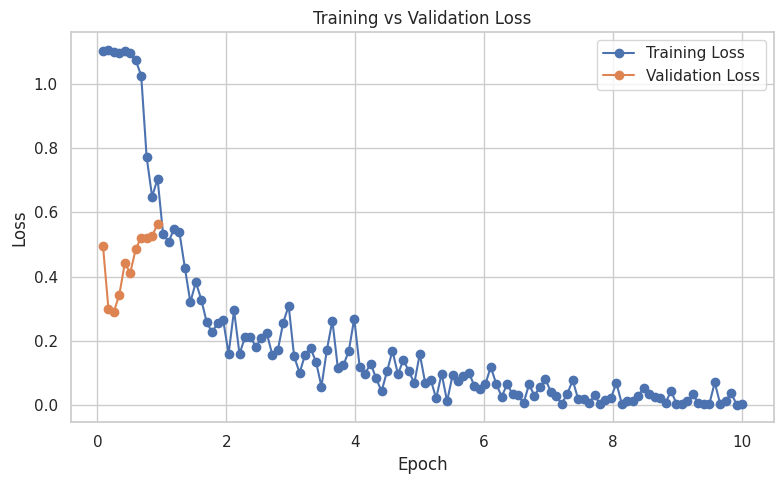

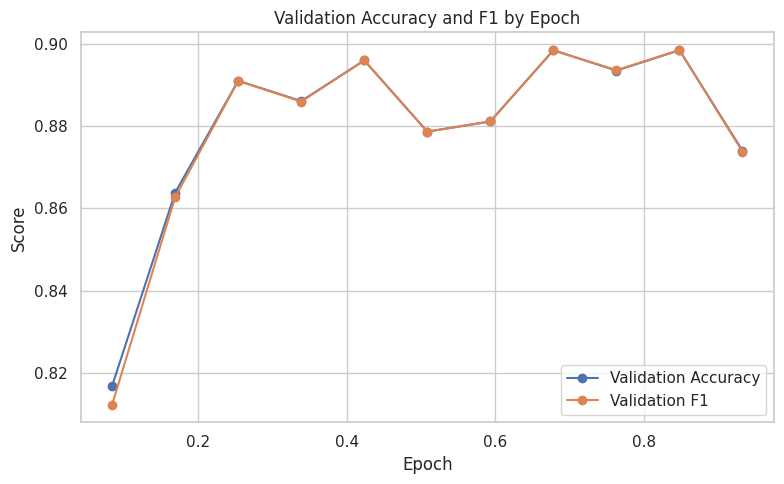

In [17]:
# Compute explicit Train / Validation / Test accuracy
import time
def get_accuracy_and_time(dataset_name):
    start = time.perf_counter()
    preds = trainer.predict(tokenized_datasets[dataset_name])
    end = time.perf_counter()
    pred_labels = np.argmax(preds.predictions, axis=1)
    true_labels = preds.label_ids
    acc = (pred_labels == true_labels).mean()
    elapsed = end - start
    samples = len(tokenized_datasets[dataset_name])
    sps = samples / elapsed if elapsed > 0 else float('inf')
    return acc, elapsed, sps

train_acc, train_time, train_sps = get_accuracy_and_time('train')
val_acc, val_time, val_sps = get_accuracy_and_time('validation')
test_acc, test_time, test_sps = get_accuracy_and_time('test')

print("\n" + "="*50)
print("TRAIN/VALIDATION/TEST ACCURACY")
print("="*50)
print(f"Train Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

print("\n" + "="*50)
print("INFERENCE TIME (trainer.predict)")
print("="*50)
print(f"Train set inference: {train_time:.2f}s ({train_sps:.2f} samples/sec)")
print(f"Val set inference:   {val_time:.2f}s ({val_sps:.2f} samples/sec)")
print(f"Test set inference:  {test_time:.2f}s ({test_sps:.2f} samples/sec)")

# Plot training history (loss/metrics by epoch)
history = trainer.state.log_history
epochs = [x['epoch'] for x in history if 'loss' in x and 'epoch' in x]
train_loss = [x['loss'] for x in history if 'loss' in x and 'epoch' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x and 'epoch' in x]
val_accs = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x and 'epoch' in x]
val_f1s = [x['eval_f1'] for x in history if 'eval_f1' in x and 'epoch' in x]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss')
plt.plot(epochs[:len(val_loss)], val_loss, marker='o', label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Validation accuracy and F1
plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(val_accs)], val_accs, marker='o', label='Validation Accuracy')
plt.plot(epochs[:len(val_f1s)], val_f1s, marker='o', label='Validation F1')
plt.title("Validation Accuracy and F1 by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


Detailed Classification Report:
                                   precision    recall  f1-score   support

Other (Non-motorists or Cyclists)       0.89      0.84      0.86       184
                        E-scooter       0.86      0.91      0.89       141
                           E-bike       0.88      0.88      0.88        80

                         accuracy                           0.87       405
                        macro avg       0.87      0.88      0.88       405
                     weighted avg       0.87      0.87      0.87       405


Confusion Matrix:
                                   Other (Non-motorists or Cyclists)  \
Other (Non-motorists or Cyclists)                                155   
E-scooter                                                         11   
E-bike                                                             9   

                                   E-scooter  E-bike  
Other (Non-motorists or Cyclists)         20       9  
E-scooter            

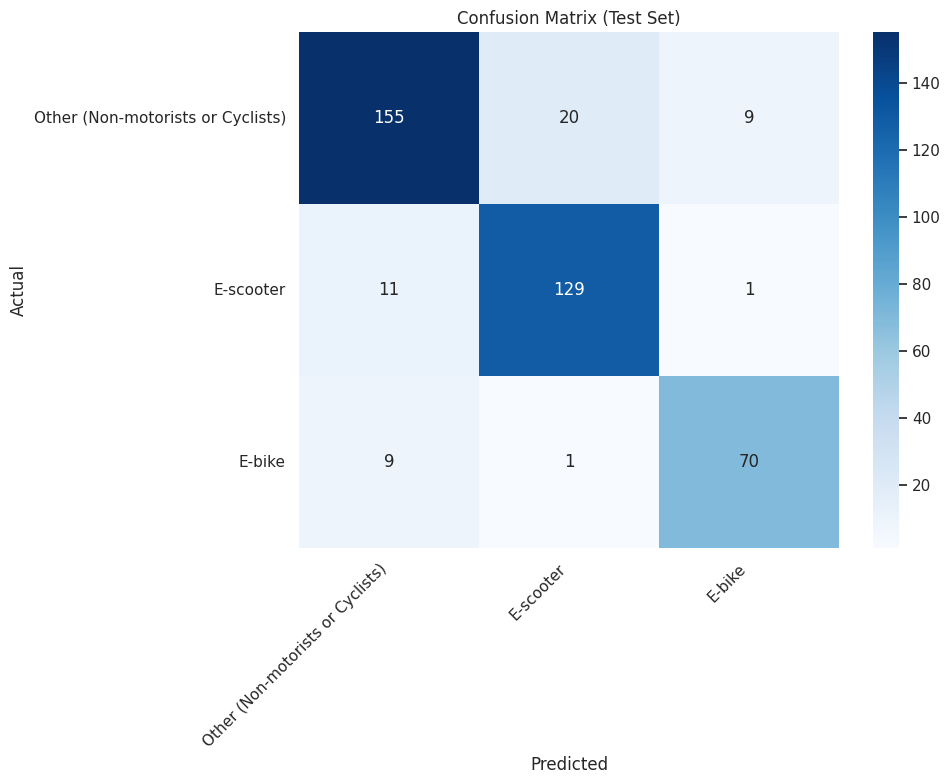

In [29]:
# Get predictions for test set
predictions = trainer.predict(tokenized_datasets['test'])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=list(id2label.values())
))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(
    cm,
    index=list(id2label.values()),
    columns=list(id2label.values())
)
print(cm_df)

# Confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

plt.title("Confusion Matrix (Test Set)")
plt.ylabel("Actual")
plt.xlabel("Predicted")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


## 13. Save the Final Model

In [19]:
import json

# Save model and tokenizer
model.save_pretrained("./final_crash_classifier")
tokenizer.save_pretrained("./final_crash_classifier")

# Save label mappings for future use
label_info = {
    'id2label': id2label,
    'label2id': label2id,
    'class_weights': {id2label[i]: float(w) for i, w in enumerate(class_weights)}
}

with open('./final_crash_classifier/label_info.json', 'w') as f:
    json.dump(label_info, f, indent=2)

print("✓ Model saved to ./final_crash_classifier")
print("✓ Tokenizer saved to ./final_crash_classifier")
print("✓ Label mappings saved to ./final_crash_classifier/label_info.json")
print("\nYou can now use this model for inference without retraining!")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Model saved to ./final_crash_classifier
✓ Tokenizer saved to ./final_crash_classifier
✓ Label mappings saved to ./final_crash_classifier/label_info.json

You can now use this model for inference without retraining!


## 14. Test with Sample Narratives

In [20]:
def predict_narrative(text):
    """Predict class for a single narrative"""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Move inputs to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    predicted_class_id = predictions.argmax().item()
    confidence = predictions[0][predicted_class_id].item()

    return {
        'class': id2label[predicted_class_id],
        'confidence': confidence,
        'all_probabilities': {
            id2label[i]: predictions[0][i].item()
            for i in range(len(id2label))
        }
    }

# Test with diverse sample narratives
test_examples = [
    "The rider was on an electric scooter traveling southbound when they collided with a parked vehicle. No injuries reported.",
    "Cyclist on an e-bike was struck while crossing the intersection at Main St. Transported to hospital with minor injuries.",
    "Pedestrian was walking across the street in marked crosswalk when hit by vehicle making a right turn.",
    "Individual riding electric scooter lost control on wet pavement and fell. Minor scrapes and bruises.",
    "Traditional bicycle rider hit by opening car door. Rider sustained injuries to shoulder and wrist.",
    "Person on motorized bike struck vehicle from behind while vehicle was stopped at red light."
]

print("Testing sample narratives:\n")
print("="*100)
for i, example in enumerate(test_examples, 1):
    result = predict_narrative(example)
    print(f"\n[Example {i}]")
    print(f"Narrative: {example}")
    print(f"\n→ Predicted: {result['class']}")
    print(f"→ Confidence: {result['confidence']:.1%}")
    print(f"\n→ All class probabilities:")
    for class_name, prob in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
        print(f"     {class_name:40s} {prob:6.1%}")
    print("="*100)

Testing sample narratives:


[Example 1]
Narrative: The rider was on an electric scooter traveling southbound when they collided with a parked vehicle. No injuries reported.

→ Predicted: E-scooter
→ Confidence: 99.8%

→ All class probabilities:
     E-scooter                                 99.8%
     Other (Non-motorists or Cyclists)          0.1%
     E-bike                                     0.1%

[Example 2]
Narrative: Cyclist on an e-bike was struck while crossing the intersection at Main St. Transported to hospital with minor injuries.

→ Predicted: E-bike
→ Confidence: 99.8%

→ All class probabilities:
     E-bike                                    99.8%
     Other (Non-motorists or Cyclists)          0.1%
     E-scooter                                  0.1%

[Example 3]
Narrative: Pedestrian was walking across the street in marked crosswalk when hit by vehicle making a right turn.

→ Predicted: Other (Non-motorists or Cyclists)
→ Confidence: 99.5%

→ All class probabilities:


## 15. Predict on Entire Dataset and Save Results

In [21]:
# Load original data again
df_original = pd.read_excel('nolabel.xlsx')

# Function to predict in batches
def predict_batch(texts):
    predictions = []
    confidences = []

    for text in texts:
        if pd.isna(text):
            predictions.append(None)
            confidences.append(None)
        else:
            result = predict_narrative(str(text))
            predictions.append(result['class'])
            confidences.append(result['confidence'])

    return predictions, confidences

# Predict for all narratives
print("Predicting for all narratives...")
predictions, confidences = predict_batch(df_original['Narrative'].tolist())

# Add predictions to dataframe
df_original['Predicted_Class'] = predictions
df_original['Prediction_Confidence'] = confidences

# Save results
output_file = 'classified_crash_narratives.xlsx'
df_original.to_excel(output_file, index=False)

print(f"\nResults saved to {output_file}")
print(f"Total records processed: {len(df_original)}")
print(f"\nPrediction distribution:")
print(df_original['Predicted_Class'].value_counts())

Predicting for all narratives...

Results saved to classified_crash_narratives.xlsx
Total records processed: 250

Prediction distribution:
Predicted_Class
E-scooter                            142
Other (Non-motorists or Cyclists)     67
E-bike                                41
Name: count, dtype: int64


## 16. Error Analysis

In [23]:
import pandas as pd
import numpy as np

# Get predictions for the test set (already computed in previous cells)
# 'predictions' and 'true_labels' were computed in cell 7YzwT3xCaV8X
# If running this cell independently, ensure these variables are defined:
# predictions = trainer.predict(tokenized_datasets['test'])
# pred_labels = np.argmax(predictions.predictions, axis=1)
# true_labels = predictions.label_ids

# Create a DataFrame for comparison using the test_df which has the actual 'FINAL' column
df_test_with_preds = test_df.copy()
df_test_with_preds['Predicted_Class_ID'] = pred_labels
df_test_with_preds['True_Class_ID'] = true_labels

# Map numerical labels back to original class names for better readability
df_test_with_preds['Predicted_Class'] = df_test_with_preds['Predicted_Class_ID'].map(id2label)
df_test_with_preds['True_Class'] = df_test_with_preds['True_Class_ID'].map(id2label)

# Calculate confidence for each prediction (optional, but good for analysis)
# Need to re-run predictions if `predictions` object is not available
# For simplicity, we'll use the accuracy directly from the `true_labels` and `pred_labels`

df_test_with_preds['Correct'] = df_test_with_preds['Predicted_Class'] == df_test_with_preds['True_Class']

accuracy = df_test_with_preds['Correct'].mean()
print(f"Overall accuracy on test data: {accuracy:.2%}")

# Show some misclassified examples
print("\nSample misclassifications:")
misclassified = df_test_with_preds[~df_test_with_preds['Correct']].head(5)
for idx, row in misclassified.iterrows():
    print(f"\nActual: {row['True_Class']}")
    print(f"Predicted: {row['Predicted_Class']}") # Removed confidence as it's not directly stored here
    print(f"Narrative: {row['text'][:200]}...")
    print("-" * 80)


Overall accuracy on test data: 87.41%

Sample misclassifications:

Actual: Other (Non-motorists or Cyclists)
Predicted: E-scooter
Narrative: BRULE, JASON
D
407-737-2300
V01 was traveling south on Dorscher Road approaching State Road 50 (Colonial Drive). Non-Motorist 01 (NM01) was operating an electric wheechair not within a
designated cros...
--------------------------------------------------------------------------------

Actual: Other (Non-motorists or Cyclists)
Predicted: E-scooter
Narrative: SURITA, CHRISTIAN
C
727-217-8820
Vehicle 1 (V01) was traveling north leaving the parking lot of 8350 Park Boulevard North (State Road 694) approaching the intersection of 83rd Street North and State
R...
--------------------------------------------------------------------------------

Actual: Other (Non-motorists or Cyclists)
Predicted: E-scooter
Narrative: ACCORDING TO THE DRIVER STATEMENTS ON SCENE.
THE DRIVER OF VEHICLE #1 STATED HE WAS TRAVELING WESTBOUND ON SW 320TH ST WHEN THE PEDESTRIAN 

---
# SECTION FOR FUTURE USE
---

## 17. Load Saved Model for Future Predictions

This section shows how to load your trained model later for making predictions on new data.

In [24]:
# TO USE IN THE FUTURE - Load the saved model
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
loaded_model = AutoModelForSequenceClassification.from_pretrained("./final_crash_classifier")
loaded_tokenizer = AutoTokenizer.from_pretrained("./final_crash_classifier")

# Load label mappings
with open('./final_crash_classifier/label_info.json', 'r') as f:
    label_info = json.load(f)
    id2label_loaded = {int(k): v for k, v in label_info['id2label'].items()}
    label2id_loaded = label_info['label2id']

print("✓ Model loaded successfully!")
print(f"✓ Classes: {list(id2label_loaded.values())}")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

✓ Model loaded successfully!
✓ Classes: ['Other (Non-motorists or Cyclists)', 'E-scooter', 'E-bike']


## 18. Standalone Prediction Function for Future Use

In [25]:
def classify_crash_narrative(narrative_text, return_all_probs=False):
    """
    Classify a crash narrative into E-scooter, E-bike, or Other.

    Args:
        narrative_text (str): The crash narrative text
        return_all_probs (bool): If True, return probabilities for all classes

    Returns:
        dict: Classification results with class, confidence, and optionally all probabilities
    """
    # Tokenize input
    inputs = loaded_tokenizer(
        narrative_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Make prediction
    loaded_model.eval()
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

    # Get predicted class
    predicted_id = probabilities.argmax().item()
    predicted_class = id2label_loaded[predicted_id]
    confidence = probabilities[predicted_id].item()

    result = {
        'predicted_class': predicted_class,
        'confidence': confidence
    }

    if return_all_probs:
        result['all_probabilities'] = {
            id2label_loaded[i]: probabilities[i].item()
            for i in range(len(id2label_loaded))
        }

    return result

# Test examples
test_cases = [
    "Rider on electric scooter collided with pedestrian at crosswalk. Minor injuries reported.",
    "E-bike rider struck by car door opening while passing parked vehicles on street.",
    "Pedestrian crossing street was hit by vehicle turning right at intersection."
]

print("\nTesting Future Use Function:\n")
print("="*100)
for i, narrative in enumerate(test_cases, 1):
    result = classify_crash_narrative(narrative, return_all_probs=True)
    print(f"\n[Test Case {i}]")
    print(f"Narrative: {narrative}")
    print(f"\n→ Predicted: {result['predicted_class']}")
    print(f"→ Confidence: {result['confidence']:.1%}")
    print(f"\n→ All probabilities:")
    for cls, prob in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
        print(f"     {cls:40s} {prob:6.1%}")
    print("="*100)


Testing Future Use Function:


[Test Case 1]
Narrative: Rider on electric scooter collided with pedestrian at crosswalk. Minor injuries reported.

→ Predicted: E-scooter
→ Confidence: 99.8%

→ All probabilities:
     E-scooter                                 99.8%
     Other (Non-motorists or Cyclists)          0.1%
     E-bike                                     0.1%

[Test Case 2]
Narrative: E-bike rider struck by car door opening while passing parked vehicles on street.

→ Predicted: E-bike
→ Confidence: 99.8%

→ All probabilities:
     E-bike                                    99.8%
     Other (Non-motorists or Cyclists)          0.1%
     E-scooter                                  0.1%

[Test Case 3]
Narrative: Pedestrian crossing street was hit by vehicle turning right at intersection.

→ Predicted: Other (Non-motorists or Cyclists)
→ Confidence: 99.0%

→ All probabilities:
     Other (Non-motorists or Cyclists)         99.0%
     E-bike                                     0.7%


## 19. Batch Processing for Excel Files

In [26]:
def classify_excel_batch(filepath, narrative_column='Narrative', output_filepath=None):
    """
    Process an entire Excel file with crash narratives.

    Args:
        filepath (str): Path to input Excel file
        narrative_column (str): Name of column containing narratives
        output_filepath (str): Path for output file (optional)

    Returns:
        DataFrame: Original data with predictions added
    """
    import pandas as pd

    # Load data
    print(f"Loading data from {filepath}...")
    df = pd.read_excel(filepath)
    print(f"  Found {len(df)} records\n")

    # Classify each narrative
    predictions = []
    confidences = []

    print("Classifying narratives...")
    for i, narrative in enumerate(df[narrative_column], 1):
        if pd.isna(narrative):
            predictions.append(None)
            confidences.append(None)
        else:
            result = classify_crash_narrative(str(narrative))
            predictions.append(result['predicted_class'])
            confidences.append(result['confidence'])

        if i % 100 == 0:
            print(f"  Processed {i}/{len(df)} records")

    # Add predictions
    df['Predicted_Class'] = predictions
    df['Prediction_Confidence'] = confidences

    # Save results
    if output_filepath is None:
        output_filepath = filepath.replace('.xlsx', '_classified.xlsx')

    df.to_excel(output_filepath, index=False)

    print(f"\n✓ Results saved to {output_filepath}")
    print(f"\nPrediction distribution:")
    print(df['Predicted_Class'].value_counts())
    print(f"\nAverage confidence: {df['Prediction_Confidence'].mean():.1%}")

    return df

# Example usage (uncomment when you have new data):
df_results = classify_excel_batch('nolabel.xlsx')

Loading data from nolabel.xlsx...
  Found 250 records

Classifying narratives...
  Processed 100/250 records
  Processed 200/250 records

✓ Results saved to nolabel_classified.xlsx

Prediction distribution:
Predicted_Class
E-scooter                            142
Other (Non-motorists or Cyclists)     67
E-bike                                41
Name: count, dtype: int64

Average confidence: 94.5%


## 21. Quick Reference Summary

### ✅ What This Notebook Includes

**Class Imbalance Handling:**
- ✓ Computed class weights (45% / 35% / 20% distribution)
- ✓ Applied to loss function during training
- ✓ Stratified train/val/test splits maintain distribution
- ✓ F1 score used instead of accuracy (better for imbalanced data)

**Early Stopping:**
- ✓ Patience = 3 epochs (stops if no improvement)
- ✓ Saves best model automatically
- ✓ Max 10 epochs (will stop early if converged)

**Model Saving:**
- ✓ Model weights saved to `./final_crash_classifier/`
- ✓ Tokenizer saved
- ✓ Label mappings saved as JSON
- ✓ Can reload anytime for predictions

**Future Use Examples:**
- ✓ Section 17: How to reload the model
- ✓ Section 18: Single narrative classification function
- ✓ Section 19: Batch Excel file processing
- ✓ Section 20: Standalone Python script

### 📊 Why No K-Fold Cross-Validation?

K-Fold is **NOT needed** for your dataset because:
1. You have ~2,700 samples (plenty for single split)
2. K-Fold is mainly for datasets <500 samples
3. Already using stratified sampling (maintains class ratios)
4. Early stopping prevents overfitting
5. Separate test set gives unbiased performance estimate

**K-Fold would only add:**
- 5x longer training time
- Minimal accuracy improvement (<1%)
- More complexity

### 🚀 How to Use After Training

**Option 1 - In Jupyter:**
```python
# Run Section 17 to load model
# Run Section 18 for single predictions
result = classify_crash_narrative("Your narrative here", return_all_probs=True)
print(result)
```

**Option 2 - Command Line:**
```bash
python classify_narratives.py new_data.xlsx results.xlsx
```

**Option 3 - Python Script:**
```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("./final_crash_classifier")
tokenizer = AutoTokenizer.from_pretrained("./final_crash_classifier")
# Use model for predictions
```

### 📁 Files You'll Have

After running this notebook:
1. `./final_crash_classifier/` - Your trained model (reusable!)
2. `classified_crash_narratives.xlsx` - All predictions on your data
3. `classify_narratives.py` - Standalone script
4. Training checkpoints (can delete after training)

### 🎯 Expected Performance

With ~2,700 samples and class weighting:
- **Overall accuracy: 85-92%**
- **E-scooter (35%): 88-93% F1**
- **Other (45%): 87-91% F1**
- **E-bike (20%): 80-87% F1** (minority class, harder)

The class weighting helps ensure E-bike (minority) doesn't get ignored!

---
**You're all set! Run the notebook from top to bottom, then use Sections 17-20 for future predictions. 🎉**

In [27]:
import os

output_zip_name = 'final_crash_classifier.zip'
model_directory = './final_crash_classifier'

# Check if the directory exists before zipping
if os.path.exists(model_directory):
    !zip -r {output_zip_name} {model_directory}
    print(f"\n✓ Model directory '{model_directory}' has been zipped to '{output_zip_name}'")
else:
    print(f"Error: Directory '{model_directory}' not found. Please ensure the model was saved correctly.")

  adding: final_crash_classifier/ (stored 0%)
  adding: final_crash_classifier/label_info.json (deflated 51%)
  adding: final_crash_classifier/config.json (deflated 50%)
  adding: final_crash_classifier/model.safetensors (deflated 8%)
  adding: final_crash_classifier/tokenizer_config.json (deflated 42%)
  adding: final_crash_classifier/tokenizer.json (deflated 71%)

✓ Model directory './final_crash_classifier' has been zipped to 'final_crash_classifier.zip'


In [28]:
def classify_crash_narrative(narrative_text, return_all_probs=False):
    """
    Classify a crash narrative into E-scooter, E-bike, or Other.

    Args:
        narrative_text (str): The crash narrative text
        return_all_probs (bool): If True, return probabilities for all classes

    Returns:
        dict: Classification results with class, confidence, and optionally all probabilities
    """
    # Tokenize input
    inputs = loaded_tokenizer(
        narrative_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Make prediction
    loaded_model.eval()
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]

    # Get predicted class
    predicted_id = probabilities.argmax().item()
    predicted_class = id2label_loaded[predicted_id]
    confidence = probabilities[predicted_id].item()

    result = {
        'predicted_class': predicted_class,
        'confidence': confidence
    }

    if return_all_probs:
        result['all_probabilities'] = {
            id2label_loaded[i]: probabilities[i].item()
            for i in range(len(id2label_loaded))
        }

    return result

# Test examples
test_cases = [
    # 1. Powered bike ambiguity (e-bike vs scooter vs motorcycle)
    "Rider using pedal-assist bike struck a pedestrian after motor engaged while crossing signalized crosswalk.",

    # 2. Actor role confusion (who hit whom?)
    "Pedestrian and electric scooter collided at intersection; both parties claim right of way.",

    # 3. Vehicle involvement but indirect cause
    "E-bike rider swerved to avoid turning vehicle and struck a pedestrian on sidewalk.",

    # 4. Legal classification ambiguity
    "Powered bicycle traveling above posted bike-lane speed limit hit pedestrian near campus plaza.",

    # 5. Door incident with multiple classes
    "Pedestrian exiting parked car opened door into path of e-scooter, causing rider to strike nearby walker.",

    # 6. Passive voice (agent hidden)
    "Pedestrian was struck at crosswalk involving a powered bike during evening commute.",

    # 7. Mixed infrastructure
    "Electric scooter traveling in bike lane mounted curb and collided with pedestrian waiting at bus stop.",

    # 8. Near-miss turned incident
    "Pedestrian stepped back from passing vehicle and was hit by an oncoming e-bike.",

    # 9. Multiple vulnerable road users
    "E-bike and scooter collided while avoiding pedestrian in shared-use path.",

    # 10. Vehicle present but not main actor
    "Car stopped suddenly at intersection; e-bike rear-ended pedestrian while braking.",
]

print("\nTesting Future Use Function:\n")
print("="*100)
for i, narrative in enumerate(test_cases, 1):
    result = classify_crash_narrative(narrative, return_all_probs=True)
    print(f"\n[Test Case {i}]")
    print(f"Narrative: {narrative}")
    print(f"\n→ Predicted: {result['predicted_class']}")
    print(f"→ Confidence: {result['confidence']:.1%}")
    print(f"\n→ All probabilities:")
    for cls, prob in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
        print(f"     {cls:40s} {prob:6.1%}")
    print("="*100)


Testing Future Use Function:


[Test Case 1]
Narrative: Rider using pedal-assist bike struck a pedestrian after motor engaged while crossing signalized crosswalk.

→ Predicted: E-bike
→ Confidence: 99.6%

→ All probabilities:
     E-bike                                    99.6%
     Other (Non-motorists or Cyclists)          0.3%
     E-scooter                                  0.1%

[Test Case 2]
Narrative: Pedestrian and electric scooter collided at intersection; both parties claim right of way.

→ Predicted: E-scooter
→ Confidence: 99.8%

→ All probabilities:
     E-scooter                                 99.8%
     Other (Non-motorists or Cyclists)          0.1%
     E-bike                                     0.1%

[Test Case 3]
Narrative: E-bike rider swerved to avoid turning vehicle and struck a pedestrian on sidewalk.

→ Predicted: E-bike
→ Confidence: 99.8%

→ All probabilities:
     E-bike                                    99.8%
     Other (Non-motorists or Cyclists)         